In [1]:
import sys
sys.path.append("../../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from ContrastiveModels import *
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), std=(1.0,))])

mnist_dset_train = torchvision.datasets.MNIST('../../data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(mnist_dset_train, batch_size=20, shuffle=True, num_workers=0)

mnist_dset_test = torchvision.datasets.MNIST('../../data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(mnist_dset_test, batch_size=20, shuffle=False, num_workers=0)

In [4]:
activation = hard_sigmoid
architecture = [784, 500, 10]

x,y = next(iter(train_loader))
x = x.view(x.size(0),-1).to(device).T
y_one_hot = F.one_hot(y, 10).to(device).T

beta = 1
lambda_ = 0.9999
epsilon = 0.15
one_over_epsilon = 1 / epsilon
lr_start = {'ff' : np.array([0.275, 0.1]), 'fb': np.array([0.05, 0.01])}

neural_lr_start = 0.05
neural_lr_stop = 0.001
neural_lr_rule = "constant"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations_nudged = 10
neural_dynamic_iterations_free = 20
hopfield_g = 0.01
model = ContrastiveCorInfoMax(architecture = architecture, lambda_ = lambda_, 
                              epsilon = epsilon, activation = activation)

In [5]:
# x, y = next(iter(train_loader))
# x, y = x.to(device), y.to(device)
# x = x.view(x.size(0),-1).T
# y_one_hot = F.one_hot(y, 10).to(device).T
# hopfield_g = 0.01
# neurons = model.init_neurons(x.size(1), device = model.device)
# model.run_neural_dynamics_hopfield(x, y, neurons, hopfield_g, neural_lr_start, neural_lr_stop,
#                                    neural_lr_rule, neural_lr_decay_multiplier, 
#                                    neural_dynamic_iterations_nudged, beta)

In [6]:
# x, y = next(iter(train_loader))
# x, y = x.to(device), y.to(device)
# x = x.view(x.size(0),-1).T
# y_one_hot = F.one_hot(y, 10).to(device).T

# neurons = model.fast_forward(x)
# neurons1 = neurons.copy()
# layers_free = [x] + neurons1
# Wff = model.Wff
# forward_errors_free = [layers_free[jj + 1] - model.activation(Wff[jj]['weight'] @ layers_free[jj] + Wff[jj]['bias']) for jj in range(len(Wff))]

In [7]:
_ = evaluateContrastiveCorInfoMax(model, train_loader, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                  neural_lr_decay_multiplier, neural_dynamic_iterations_free, device)

Train accuracy :	 0.1445


In [8]:
trn_acc_list = []
tst_acc_list = []

n_epochs = 25

for epoch_ in range(n_epochs):
    lr = {'ff' : lr_start['ff'] * (0.99)**epoch_, 'fb' : lr_start['fb'] * (0.99)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        if True:
            rnd_sgn = 2*np.random.randint(2) - 1
            beta = rnd_sgn*beta
            
        neurons = model.batch_step_hopfield(  x, y_one_hot, hopfield_g, lr, neural_lr_start, 
                                              neural_lr_stop, neural_lr_rule, 
                                              neural_lr_decay_multiplier, neural_dynamic_iterations_free,
                                              neural_dynamic_iterations_nudged, beta)

    trn_acc = evaluateContrastiveCorInfoMax(model, train_loader, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                            neural_lr_decay_multiplier, neural_dynamic_iterations_free, device, printing = False)
    tst_acc = evaluateContrastiveCorInfoMax(model, test_loader, neural_lr_start, neural_lr_stop, neural_lr_rule, 
                                            neural_lr_decay_multiplier, neural_dynamic_iterations_free, device, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

3000it [00:56, 52.73it/s]
5it [00:00, 49.66it/s]

Epoch : 1, Train Accuracy : 0.8941666666666667, Test Accuracy : 0.9003


3000it [00:59, 50.72it/s]
6it [00:00, 51.14it/s]

Epoch : 2, Train Accuracy : 0.9174333333333333, Test Accuracy : 0.9208


3000it [00:59, 50.71it/s]
6it [00:00, 51.26it/s]

Epoch : 3, Train Accuracy : 0.9282666666666667, Test Accuracy : 0.9289


3000it [00:59, 50.85it/s]
6it [00:00, 50.77it/s]

Epoch : 4, Train Accuracy : 0.93805, Test Accuracy : 0.939


3000it [00:55, 53.70it/s]
4it [00:00, 33.34it/s]

Epoch : 5, Train Accuracy : 0.9446833333333333, Test Accuracy : 0.9445


3000it [00:54, 55.33it/s]
4it [00:00, 33.56it/s]

Epoch : 6, Train Accuracy : 0.94905, Test Accuracy : 0.947


3000it [00:57, 52.24it/s]
6it [00:00, 52.98it/s]

Epoch : 7, Train Accuracy : 0.9538, Test Accuracy : 0.9524


3000it [00:58, 51.29it/s]
6it [00:00, 53.17it/s]

Epoch : 8, Train Accuracy : 0.9564833333333334, Test Accuracy : 0.9538


3000it [00:57, 52.30it/s]
6it [00:00, 55.52it/s]

Epoch : 9, Train Accuracy : 0.9592166666666667, Test Accuracy : 0.9567


3000it [00:54, 55.06it/s]
6it [00:00, 55.16it/s]

Epoch : 10, Train Accuracy : 0.96215, Test Accuracy : 0.9583


3000it [00:55, 54.25it/s]
6it [00:00, 52.81it/s]

Epoch : 11, Train Accuracy : 0.9647166666666667, Test Accuracy : 0.9616


3000it [00:55, 54.49it/s]
6it [00:00, 53.74it/s]

Epoch : 12, Train Accuracy : 0.9670166666666666, Test Accuracy : 0.9616


3000it [00:57, 52.62it/s]
6it [00:00, 51.92it/s]

Epoch : 13, Train Accuracy : 0.9684833333333334, Test Accuracy : 0.9632


3000it [00:57, 52.50it/s]
6it [00:00, 56.14it/s]

Epoch : 14, Train Accuracy : 0.9694833333333334, Test Accuracy : 0.9632


3000it [00:57, 51.80it/s]
6it [00:00, 52.84it/s]

Epoch : 15, Train Accuracy : 0.9709666666666666, Test Accuracy : 0.9659


3000it [00:55, 54.30it/s]
6it [00:00, 52.86it/s]

Epoch : 16, Train Accuracy : 0.97235, Test Accuracy : 0.9664


3000it [00:55, 53.64it/s]
3it [00:00, 29.02it/s]

Epoch : 17, Train Accuracy : 0.9731833333333333, Test Accuracy : 0.9665


3000it [00:56, 52.80it/s]
6it [00:00, 52.24it/s]

Epoch : 18, Train Accuracy : 0.9744666666666667, Test Accuracy : 0.9679


3000it [00:57, 52.58it/s]
6it [00:00, 51.77it/s]

Epoch : 19, Train Accuracy : 0.975, Test Accuracy : 0.9688


3000it [00:59, 50.46it/s]
6it [00:00, 57.40it/s]

Epoch : 20, Train Accuracy : 0.9756666666666667, Test Accuracy : 0.9679


3000it [00:56, 52.80it/s]
6it [00:00, 56.84it/s]

Epoch : 21, Train Accuracy : 0.9762333333333333, Test Accuracy : 0.969


3000it [00:56, 53.54it/s]
6it [00:00, 55.28it/s]

Epoch : 22, Train Accuracy : 0.9772166666666666, Test Accuracy : 0.969


3000it [00:55, 54.06it/s]
6it [00:00, 53.36it/s]

Epoch : 23, Train Accuracy : 0.9772833333333333, Test Accuracy : 0.9686


3000it [00:55, 53.80it/s]
5it [00:00, 48.74it/s]

Epoch : 24, Train Accuracy : 0.9785666666666667, Test Accuracy : 0.971


3000it [00:57, 52.54it/s]


Epoch : 25, Train Accuracy : 0.9790166666666666, Test Accuracy : 0.97


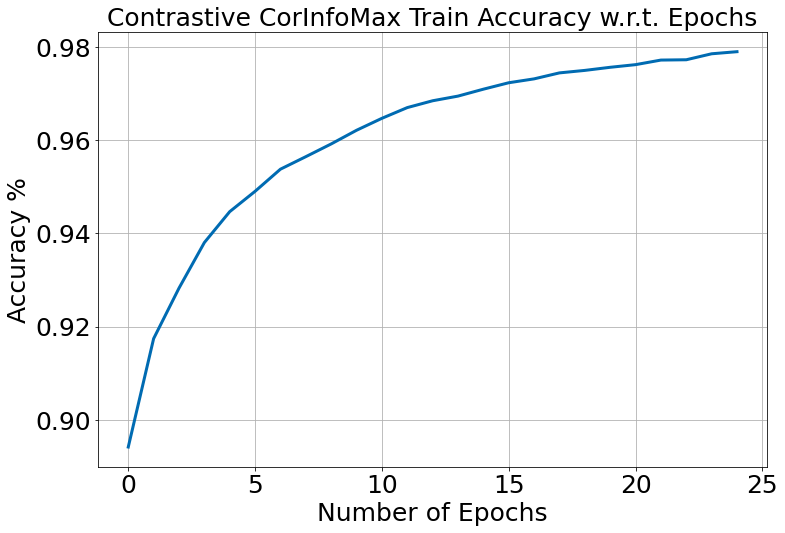

In [9]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

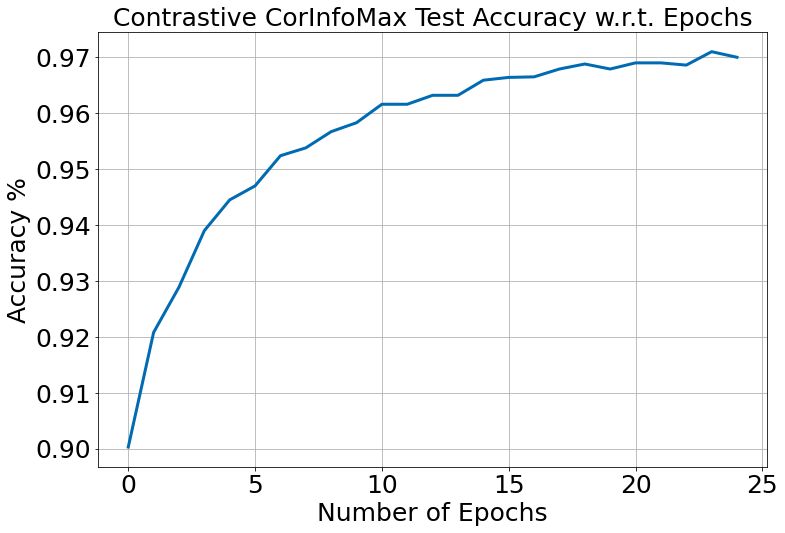

In [10]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'Contrastive CorInfoMax Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

In [ ]:
from IPython.display import Math, display
########### LATEX Style Display Matrix ###############
def display_matrix(array):
    """Display given numpy array with Latex format in Jupyter Notebook.
    Args:
        array (numpy array): Array to be displayed
    """
    data = ""
    for line in array:
        if len(line) == 1:
            data += " %.3f &" % line + r" \\\n"
            continue
        for element in line:
            data += " %.3f &" % element
        data += r" \\" + "\n"
    display(Math("\\begin{bmatrix} \n%s\\end{bmatrix}" % data))

In [ ]:
display_matrix(model.B[0]['weight'][:10,:10])

In [ ]:
# display_matrix(torch.linalg.inv(model.Rh1)[:10,:10])

In [ ]:
# torch.norm(model.B[0]['weight'] - torch.linalg.inv(model.Rh1))

In [ ]:
# display_matrix(torch.linalg.inv(model.Rh2)[:10,:10])